## Modified Slim

In [1]:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
from matplotlib import pyplot as plt
import os
import deepxde as dde
from utils.gs_solovev_sol import GS_Linear
from deepxde.config import set_default_float
set_default_float("float64")

# from deepxde.backend import set_default_backend
# set_default_backend("pytorch") 

######################
# ITER Configuration #
######################
A = -0.155
eps = 0.32
kappa = 1.7
delta = 0.33
# A = -0.155
# eps = 0.2  
# kappa = 1.7 
# delta = 0.5 

N1 = - (1 + np.arcsin(delta)) ** 2 / (eps * kappa ** 2)
N2 = (1 - np.arcsin(delta)) ** 2 / (eps * kappa ** 2)
N3 = - kappa / (eps * np.cos(np.arcsin(delta)) ** 2)

def gen_traindata(num):
    ######################
    # ITER Configuration #
    ######################
    eps = 0.32
    kappa = 1.7
    delta = 0.33
    N = num
    center, eps, kappa, delta = np.array([[0.0,0.0]]), eps, kappa, delta
    tau = np.linspace(0, 2 * np.pi, N)
    # Define boundary of ellipse
    # these are the R and Z in equantion (8) in paper
    x_ellipse = np.asarray([1 + eps * np.cos(tau + np.arcsin(delta) * np.sin(tau)), 
                    eps * kappa * np.sin(tau)]).T
    xvals = x_ellipse
    uvals = np.zeros(len(xvals)).reshape(len(xvals), 1)
    return xvals, uvals


def pde_solovev(x, u):
    # computes the residual of the Grad-Shafranov equation
    psi = u[:, 0:1]
    psi_r = dde.grad.jacobian(psi, x, i=0, j=0)
    psi_rr = dde.grad.hessian(psi, x, i=0, j=0)
    psi_zz = dde.grad.hessian(psi, x, i=1, j=1)
    GS = psi_rr - psi_r / x[:, 0:1] + psi_zz - (1 - A) * x[:, 0:1] ** 2 - A
    return GS

def psi_r(x,u):
    return dde.grad.jacobian(u, x, i=0, j=0)
def psi_z(x,u):
    return  dde.grad.jacobian(u, x, i=0, j=1)
def psi_rr(x, u):
    return dde.grad.hessian(u, x, i=0, j=0)
def psi_zz(x, u):
    return dde.grad.hessian(u, x, i=1, j=1)

def boundary_outer(x, on_boundary):
    return on_boundary and np.isclose([x[0], x[1]], [1 + eps, 0]).all()
def boundary_inner(x, on_boundary):
    return on_boundary and np.isclose([x[0], x[1]], [1 - eps, 0]).all()
def boundary_high(x, on_boundary):
    return on_boundary and np.isclose([x[0], x[1]], [1 - delta * eps, kappa * eps]).all()

# changed center to (0,0)
spatial_domain = dde.geometry.Ellipse(np.array([0.0,0.0]), eps, kappa, delta) 

x,u = gen_traindata(1001)   #  red dots in the boundary

n_test = 100

# specify psi, psi_r, psi_z, psi_rr, psi_zz at four locations 

observe_x = np.asarray([[1 + eps, 0], 
                        [1 - eps, 0], 
                        [1 - delta * eps, kappa * eps],
                        [1 - delta * eps, -kappa * eps]]
                    )
observe_y = np.asarray([0.0, 0.0, 0.0,0.0]).reshape(4, 1)

observe_x = np.concatenate((x,observe_x))
observe_y = np.concatenate((u,observe_y))

bc135 = dde.PointSetBC(x,u)

data = dde.data.PDE(
    spatial_domain,
    pde_solovev,
    [bc135],
    num_domain=1024,        # blue dots in paper
    num_boundary=0,        
    num_test=n_test,
    train_distribution="LHS"
)


# net = dde.maps.FNN([2] + 4 * [40] + [1], "tanh", "Glorot normal")

# model = dde.Model(data, net)


Using backend: tensorflow
Other supported backends: tensorflow.compat.v1, pytorch, jax, paddle.
paddle supports more examples now and is recommended.


Set the default float type to float64


/Users/akaptanoglu/deepxde_copy/deepxde/geometry/geometry_2d.py:95: ComplexWarning: Casting complex values to real discards the imaginary part
  self.focus1 = np.array(
/Users/akaptanoglu/deepxde_copy/deepxde/geometry/geometry_2d.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  self.focus2 = np.array(


Text(0, 0.5, '$u(r,z=0)$')

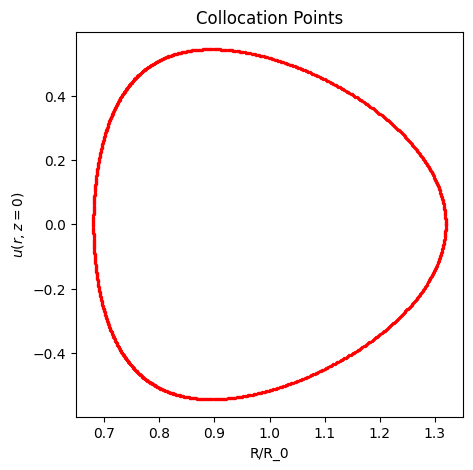

In [2]:
# Plot collocation points for visual check
fig,ax=plt.subplots(1, figsize=(5,5))
ax.scatter(data.train_x_bc[:,0], data.train_x_bc[:,1], s = 2, color='r')
ax.set_title('Collocation Points')
ax.set_xlabel('R/R_0')
ax.set_ylabel(r'$u(r,z=0)$')

## Train Model

In [3]:
# dde.backend.set_default_backend("pytorch") 

Compiling model...
'compile' took 0.002097 s

Training model...



/Users/akaptanoglu/anaconda3/envs/deepxde_copy/lib/python3.11/site-packages/tf_keras/src/initializers/initializers.py:121: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


Step      Train loss              Test loss               Test metric
0         [7.33e-02, 5.50e-04]    [1.75e-02, 5.50e-04]    []  
1         [2.11e+00, 1.27e-01]    [1.14e-01, 1.27e-01]    []  
2         [2.34e-01, 8.23e-03]    [2.67e-02, 8.23e-03]    []  
3         [1.37e-01, 2.49e-02]    [2.13e-02, 2.49e-02]    []  
4         [5.12e-01, 5.78e-02]    [3.84e-02, 5.78e-02]    []  
5         [4.52e-01, 3.78e-02]    [3.64e-02, 3.78e-02]    []  
6         [2.17e-01, 8.90e-03]    [2.61e-02, 8.90e-03]    []  
7         [5.64e-02, 3.91e-04]    [1.86e-02, 3.91e-04]    []  
8         [1.60e-02, 1.09e-02]    [1.61e-02, 1.09e-02]    []  
9         [5.22e-02, 2.34e-02]    [1.70e-02, 2.34e-02]    []  
10        [1.00e-01, 2.48e-02]    [1.87e-02, 2.48e-02]    []  
11        [1.16e-01, 1.58e-02]    [1.93e-02, 1.58e-02]    []  
12        [9.91e-02, 5.01e-03]    [1.87e-02, 5.01e-03]    []  
13        [6.68e-02, 9.01e-05]    [1.75e-02, 9.01e-05]    []  
14        [3.74e-02, 3.02e-03]    [1.66e-02, 3.0

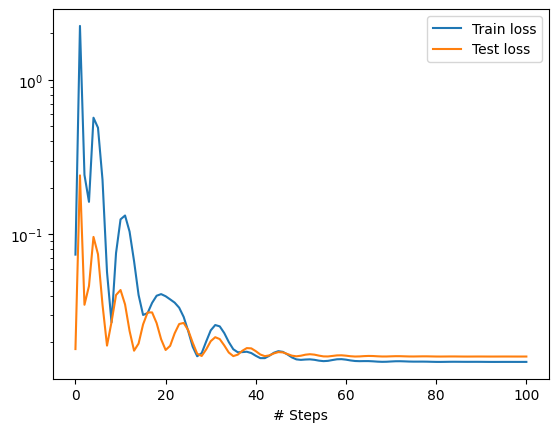

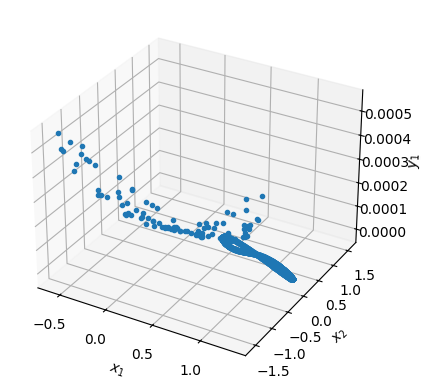

Accuracy
Mean residual: 1.0484882944696758
Mean residual for output: 0.00012948755470870162


In [4]:
# import torch
import time
# torch.set_default_tensor_type(torch.FloatTensor)
DATE = time.strftime("%m%d%Y")
CONFIG = "ITER"
LR = 2e-3   # 2e-2
DROPOUT = 0.1
DEPTH = 6  # 3
BREADTH = 64  # 20
LOSSRATIO = 200  # 100  # this is lamda1 in the paper
run = f"02_{LOSSRATIO}Adam_BFGS"
AF = "swish"
RUN_NAME = f"network_sweep_{DATE}_depth0{DEPTH}_breadth{BREADTH}_{AF}_lr{LR}-varying-short_lw1-10_{run}"
PATH = f"./cefron/{CONFIG}/runs/{RUN_NAME}"

# Check whether the specified path exists or not
isExist = os.path.exists(PATH)
if not isExist:
  # Create a new directory because it does not exist 
  os.makedirs(PATH)
  print("The new directory is created!")

net = dde.maps.FNN(
    [2] + DEPTH * [BREADTH] + [1], AF, "Glorot normal",
    # dropout_rate=DROPOUT         # AttributeError: `dropout` is not available with Keras 3.
)

# data.train_x_bc = data.train_x_bc.astype(np.float64)
# data.train_x = data.train_x.astype(np.float64)

model = dde.Model(data, net)

decay_rate = 1.0
for i in range(1):
  # Compile, train and save model
  model.compile(
      "adam", lr=LR/(decay_rate*(i+1)),
      loss_weights=[1,LOSSRATIO]
  )
  loss_history, train_state = model.train(
      epochs=100, display_every=1, #callbacks=[dde.callbacks.DropoutUncertainty()]
  )
  dde.saveplot(
      loss_history, 
      train_state, 
      issave=True, 
      isplot=True,
      output_dir=PATH
  )

# make mesh
nx = 100
ny = 100
zoom = ((1 + eps)-(1 - eps))*0.05
innerPoint = 1 - eps - zoom
outerPoint = 1 + eps + zoom
lowPoint   = -kappa * eps - zoom
highPoint  = kappa * eps + zoom
x, y = np.meshgrid(
    np.linspace(innerPoint, outerPoint, nx),
    np.linspace(lowPoint, highPoint, ny),
)
X = np.vstack((np.ravel(x), np.ravel(y))).T.astype(np.float64)  # astype(np.float32)
output = model.predict(X)   # is the magnetic flux function psi
GS = model.predict(X, operator=pde_solovev)  # is the residual of the Grad-Shafranov equation
residual_psi = np.mean(np.absolute(GS))

print("Accuracy")
print("Mean residual:", residual_psi)
print("Mean residual for output:", np.mean(np.absolute(output)))

## Plotting

#### Before BFGS

(501, 501)


Average normalized percent error =  424.6681909827645
Max normalized percent error =  679.2338717230626


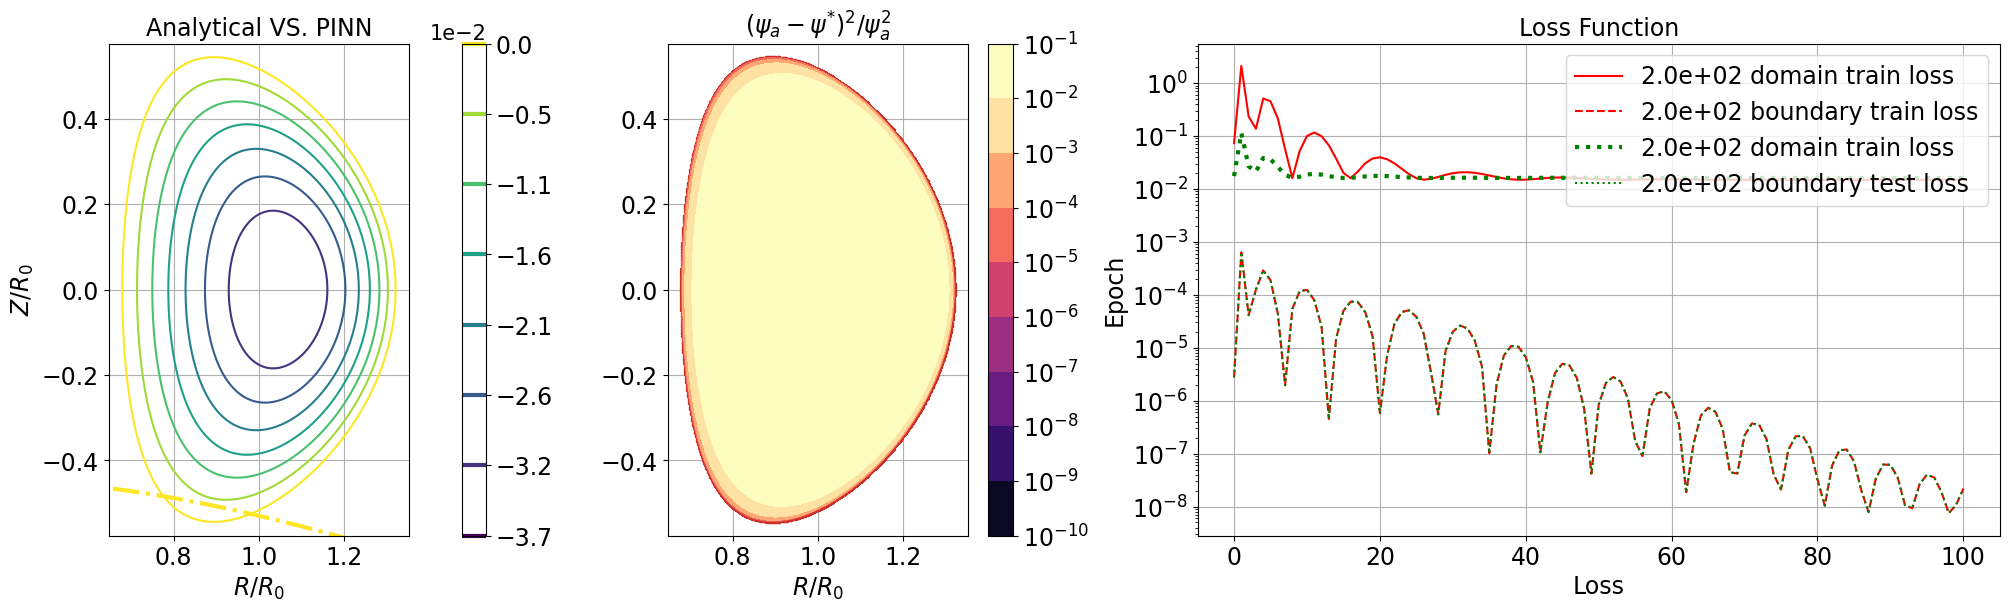

In [5]:
# Evaluation
from utils.utils import *
ITER = GS_Linear(eps=0.32, kappa=1.7, delta=0.33)
ITER.get_BCs(A)
ITER.solve_coefficients()
X_test = spatial_domain.random_points(333)
plot_summary_figure(ITER, model, X_test=X_test, losshistory = loss_history, loss_ratio = LOSSRATIO, PATH = PATH)

#### After BFGS

In [ ]:
# Compile, train and save model
model.compile(
    "L-BFGS-B",
    loss_weights=[1,100]
)
loss_history, train_state = model.train(
    epochs=1000, display_every=10, #callbacks=[dde.callbacks.DropoutUncertainty()]
)
dde.saveplot(
    loss_history, 
    train_state, 
    issave=True, 
    isplot=True,
    output_dir=PATH
)

Compiling model...
'compile' took 0.004067 s

Training model...

Step      Train loss              Test loss               Test metric
100       [1.49e-02, 2.17e-06]    [1.61e-02, 2.17e-06]    []  


In [ ]:
# Evaluation
x, y, psi_pred, psi_true, error = evaluate(ITER, model)
# x_eq, psi_true_eq, psi_pred_eq, e_eq = evaluate_eq(ITER, model)
X_test = spatial_domain.random_points(333)
plot_summary_figure(ITER, model, X_test, losshistory = loss_history, loss_ratio = LOSSRATIO, PATH = PATH)

In [ ]:
engineering_params = compute_params(x, y, psi_true, psi_pred)

## 